<a href="https://colab.research.google.com/github/arashfahim/Stochastic_Control_FSU/blob/main/Discrete_time_DPP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [55]:
!git clone https://github.com/arashfahim/Stochastic_Control_FSU

fatal: destination path 'Stochastic_Control_FSU' already exists and is not an empty directory.


In [56]:
! ls -l

total 12
drwx------ 6 root root 4096 Nov  7 15:48 drive
drwxr-xr-x 1 root root 4096 Nov  3 18:00 sample_data
drwxr-xr-x 4 root root 4096 Nov  7 15:47 Stochastic_Control_FSU


In [57]:
path = r'/content/Stochastic_Control_FSU/arashfahim/Stochastic_Control_FSU/'

In [58]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


The goal of this notebook is to implement a one-step dynamic programming principle, DPP, for a stochastic control problem.

The stochastic control problem is given by

$\inf_{u_0,...u_{T-1}}\mathbb{E}\bigg[\sum_{t=0}^{T-1}C(t,X^u_t,u_t)+g(X^u_T)\bigg]$




The DPP is given by

$\begin{cases}
V(t,x)=\inf_{u\in\mathbb{R}^d}\mathbb{E}[C(t,x,u)+V(t+1,X^u_{t+1})]\\
V(T,x)=g(x)
\end{cases}$

with $X^u_{t+1}=x+\mu(t,x,u)+\sigma(t,x,u)\xi_{t+1}$

In [59]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from time import strftime, localtime
import torch.optim as optim #import optimizer
# import torch.optim.lr_scheduler as lr_scheduler

M =10000# number of samples
X = torch.normal(0., 1., size=(M,1))# samples for X~N(0,1)
Y = torch.exp(-X)+torch.exp(X)*torch.normal(0., 1., size=(M,1))# samples for Y=e^{-x}+e^{x}N(0,1)
# X.shape
T=1# terminal horizon
N = 10 # of time steps
Dt= torch.Tensor([T/N])# time step size

In [60]:
# create time stamp to save the result
stamp = strftime('%Y-%m-%d %H:%M:%S', localtime())
print(str(stamp))

2023-11-07 16:23:34


In [61]:
# for p in model3.parameters():
#   print(p)

## Write one-step DPP as

$V(t,x)=\inf_{u(x)}C(t,x,u(x))+\mathbb{E}^{B}[V(t+1,X^u_{t+1})]$

Formulate the loss function as

$\inf_{\theta}\mathbb{E}^{X_t,B}\bigg[C(t,X_t,u(X_t;\theta))+V\Big(t+1,X_{t}+\mu\big(t,X_{t},u(X_t;\theta)\big)\Delta t+\sigma\big(t,X_{t},u(X_t;\theta)\big)\Delta B_{t+1})\Big)\bigg]$

The empirical loss is given base on a sample of $X_t$, $\{x^j\}$ and $N(0,1)$, $\{\xi^j\}$, independently.

$\inf_{\theta}\sum_{j}\bigg[C(t,x^j,u(x^j;\theta))+V\Big(t+1,x^j+\mu\big(t,x^j,u(x^j;\theta)\big)\Delta t+\sigma\big(t,x^j,u(x^j;\theta)\big)\sqrt{\Delta t} \xi^j)\Big)\bigg]$


## Creation of optimization module

We need to solve the above one-step optimization problem.

Input: $\phi(x,u,\xi)$ and $c(x,u)$

Optimize: $\inf_u\mathbb{E}[c(x,u)+\phi(x,u,\xi)]$

Output: $u^*(x)\in\textrm{argmin}\mathbb{E}[c(x,u)+\phi(x,u,\xi)]$



---

It is important to make sure the input and output are functions and not just data points.

# Multistep DPP

## At $t=T-\Delta t$

In [62]:
# increase neurons
modelu= torch.nn.Sequential(
    torch.nn.Linear(1, 16),
    torch.nn.Tanh(),
    # torch.nn.Linear(8, 8),
    # torch.nn.ReLU(),
    torch.nn.Linear(16,1)
)

In [63]:
class cost:
  def __init__(self,flag):
    self.flag = flag
  def cost(self,x,*args):
    if self.flag == 'T':
      return torch.Tensor([0.5])*torch.pow(x,2)-x
    else:
      u=args[0]
      return torch.Tensor([0.5])*torch.pow(x,2) + torch.Tensor([0.5])*torch.pow(u,2)
# goal: to add the term E[V(t+1, X^u_{t+1})|X_t=x] inside the cost function for t<T.

In [64]:
g_term = cost('T')
c = cost('')

In [65]:
x = torch.Tensor([1.0])
c.cost(x,modelu(x)),g_term.cost(x)

(tensor([0.5291], grad_fn=<AddBackward0>), tensor([-0.5000]))

### Last step with $g(X^u_{T})$

In [66]:
X = torch.normal(0., 1., size=(M,1))# samples for X~N(0,1)

In [67]:
# # increase neurons
# modelexcost= torch.nn.Sequential(
#     torch.nn.Linear(1, 16),
#     torch.nn.Tanh(),
#     # torch.nn.Linear(8, 8),
#     # torch.nn.ReLU(),
#     torch.nn.Linear(16,1)
# )

In [68]:
# for p in modelu.parameters():
#   p.requires_grad = False
# Y = g.cost(update(X,modelu(X)))
# data = torch.cat((X,Y),dim=1)
# cond_expect(data,modelexcost)


In [69]:
xi = torch.normal(0., 1., size=(M,1))#must be defined outside update because it is going to be used in the learning and we want to avoid generating samples at each epoch
def update(x,u):
  return x + (-x+u)*Dt + torch.sqrt(Dt)*xi

In [70]:
c.cost(X,modelu(X))+ g_term.cost(update(X,modelu(X)))

tensor([[-0.1183],
        [ 0.6024],
        [ 0.9855],
        ...,
        [ 0.1912],
        [ 1.2226],
        [-0.1155]], grad_fn=<AddBackward0>)

In [71]:
lr = 1e-3
num_epochs = 100
optimizer1 = optim.Adam(modelu.parameters(), lr)
L_ = torch.Tensor([-2.0])
loss = torch.Tensor([2.0])
loss_epoch = []
epoch=0
while (torch.abs(L_-loss)>1e-6) & (epoch <= num_epochs):# epoch in range(num_epochs):
  optimizer1.zero_grad()
  loss=torch.mean(c.cost(X,modelu(X))+ g_term.cost(update(X,modelu(X))))#
  loss.backward()
  optimizer1.step()
  loss_epoch.append(loss)
  if epoch>0:
    L_ = loss_epoch[epoch-1]
  if (epoch % 10==0):
    print("At epoch {} the mean error is {}.".format(epoch,loss.detach()))
  epoch += 1

At epoch 0 the mean error is 1.0927422046661377.
At epoch 10 the mean error is 1.0454453229904175.
At epoch 20 the mean error is 1.0091218948364258.
At epoch 30 the mean error is 0.9836243987083435.
At epoch 40 the mean error is 0.9674432873725891.
At epoch 50 the mean error is 0.9582542777061462.
At epoch 60 the mean error is 0.9536305665969849.
At epoch 70 the mean error is 0.9515872001647949.
At epoch 80 the mean error is 0.9508005976676941.
At epoch 90 the mean error is 0.9505387544631958.
At epoch 100 the mean error is 0.9504632949829102.


In [72]:
# Z = torch.normal(0., 1., size=(M,1))
# torch.set_printoptions(precision=10)
# print("Test on new data: MSE = {}".format(torch.mean(c.cost(Z,modelu(Z))+ g.cost(update(Z,modelu(Z))))))

In [73]:
def test_update(x,u):
  #Antithetic variables
  N = torch.normal(0., 1., size=[x.shape[0],100000])
  # M = torch.Tensor([0.1])*torch.normal(0., 1., size=[x.shape[0],100000]) - torch.Tensor([0.9])*N
  return x + (-x+modelu(x))*Dt + torch.sqrt(Dt)*N#*torch.Tensor([0.5])*(M+N)
def V(x, u):
  return c.cost(x,u)*Dt+torch.mean(g_term.cost(test_update(x,u)),axis=1).unsqueeze(1)#c.cost(x,u)+torch.mean(g.cost(test_update(x,u))),

In [74]:
x = torch.Tensor([0.0]).unsqueeze(1)
u=torch.Tensor([[0.0]])
test_update(x,u),c.cost(x,u)*Dt,torch.mean(g_term.cost(test_update(x,u)),axis=1).unsqueeze(1),torch.std(g_term.cost(test_update(x,u)),axis=1).unsqueeze(1),V(x,u)

(tensor([[ 0.0338,  0.2067, -0.5066,  ...,  0.6955,  0.2512,  0.3198]],
        grad_fn=<AddBackward0>),
 tensor([[0.]]),
 tensor([[0.0393]], grad_fn=<UnsqueezeBackward0>),
 tensor([[0.3214]], grad_fn=<UnsqueezeBackward0>),
 tensor([[0.0392]], grad_fn=<AddBackward0>))

In [75]:
# xx = torch.linspace(-3.0,3.0,50).unsqueeze(1)
# V(xx,modelu(xx)).shape

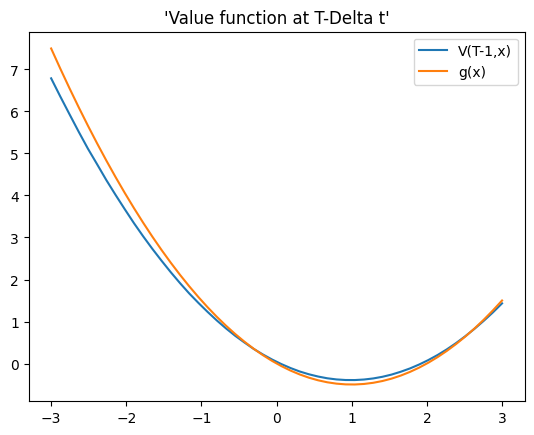

In [76]:
xx = torch.linspace(-3.0,3.0,50).unsqueeze(1)
yy = V(xx,modelu(xx))
zz = g_term.cost(xx)
plt.plot(xx.squeeze(1).detach().numpy(),yy.squeeze(1).detach().numpy(),label='V(T-1,x)');
plt.plot(xx.squeeze(1).detach().numpy(),zz.squeeze(1).detach().numpy(),label='g(x)');
plt.title("'Value function at T-Delta t'");
plt.legend();
plt.savefig(path+'test for value'+stamp+'.png');

# Object-oriented approach

A neural net in torch is an object of type _*torch.nn.Module*_. We create a child of this object which includes the needed functions used in the training.

## One-step

In [121]:
class one_step(nn.Module):
    def __init__(self,terminal,flag):
        super(one_step, self).__init__()
        self.layer = torch.nn.Sequential()
        self.layer.add_module("L1",torch.nn.Linear(1, 16))
        self.layer.add_module("Tanh", torch.nn.Tanh())
        self.layer.add_module("L2",torch.nn.Linear(16,1))
        self.flag = flag
        self.M = 1000
        self.N = torch.normal(0., 1., size=[self.M,1])
        self.terminal = terminal
        self.X = torch.normal(0., 1., size=(self.M,1))#traning set
        self.Y = None
    def forward(self, x):
        val = self.layer(x)
        return val
    def loss(self):
        #Antithetic variables
        # M = torch.Tensor([0.1])*torch.normal(0., 1., size=[self.M,1]) - torch.Tensor([0.9])*N
        update = self.X + (-self.X+self.forward(self.X))*Dt + torch.sqrt(Dt)*self.N#*torch.Tensor([0.5])*(M+N)
        # print("update shape in loss",update.shape)
        return torch.mean(self.cost(self.X)+self.terminal(update))
    def cost(self,x):#take a [N,1] tensor
        return torch.Tensor([0.5])*torch.pow(x,2) + torch.Tensor([0.5])*torch.pow(self.forward(x),2)
    def value(self):
        update = (self.X + Dt*(-self.X+self.forward(self.X))).repeat([1,self.M]).unsqueeze(2) + torch.sqrt(Dt)*torch.normal(0., 1., size=[self.X.shape[0],self.M,1])
        # print("update shape in loss",update.shape)
        self.Y = self.cost(self.X)*Dt+torch.mean(self.terminal(update),axis=1)

In [122]:
class terminal(nn.Module):
    def __init__(self,flag,*args):
        super(terminal, self).__init__()
        self.layer = torch.nn.Sequential()
        self.layer.add_module("L1",torch.nn.Linear(1, 16))
        self.layer.add_module("Tanh", torch.nn.Tanh())
        self.layer.add_module("L2",torch.nn.Linear(16,1))
        self.flag = flag
    def forward(self, x):
        if self.flag == 'T':
            return torch.Tensor([0.5])*torch.pow(x,2)-x
        else:
            val = self.layer(x)
            return val
        return x

In [123]:
g = terminal('T')
v = one_step(g,'')

In [124]:
v.value()

In [125]:
# update1 = (v.X + Dt*(-v.X+v.forward(v.X))).repeat([1,v.M]).unsqueeze(2) + torch.sqrt(Dt)*torch.normal(0., 1., size=[v.X.shape[0],v.M,1])
# # print("update shape in loss",update.shape)
# Y1 = v.cost(v.X)*Dt+torch.mean(v.terminal(update1),axis=1)

In [126]:
# update2 = (v.X + Dt*(-v.X+v.forward(v.X))).repeat([1,v.M]).unsqueeze(2) + torch.sqrt(Dt)*torch.normal(0., 1., size=[v.X.shape[0],v.M,1])
# Y2 = v.cost(v.X)*Dt+torch.mean(v.terminal(update2),axis=1)
# # update.shape, Y.shape

In [127]:
# dY = Y1-Y2
# dU =torch.mean(v.terminal(update1),axis=1)- torch.mean(v.terminal(update2),axis=1)

In [128]:
loss_epoch = []
num_epochs = 500
lr = 1e-2
optimizer1 = optim.Adam(v.parameters(), lr)
L_ = torch.Tensor([-2.0])
loss = torch.Tensor([2.0])
epoch=0
while (torch.abs(L_-loss)>1e-6) & (epoch <= num_epochs):# epoch in range(num_epochs):
  optimizer1.zero_grad()
  loss= v.loss()#self.cost(self.X,self.modelu(X))+ torch.mean(self.terminal(update(self.X,self.modelu(X))))#
  loss.backward()
  optimizer1.step()
  loss_epoch.append(loss)
  if epoch>0:
    L_ = loss_epoch[epoch-1]
  if (epoch % 10==0):
    print("At epoch {} the mean error is {}.".format(epoch,loss.detach()))
  epoch += 1

At epoch 0 the mean error is 1.0082746744155884.
At epoch 10 the mean error is 0.8908730149269104.
At epoch 20 the mean error is 0.8802144527435303.
At epoch 30 the mean error is 0.880183756351471.
At epoch 40 the mean error is 0.8780893683433533.
At epoch 50 the mean error is 0.8781099915504456.
At epoch 60 the mean error is 0.8780867457389832.
At epoch 70 the mean error is 0.8779911398887634.
At epoch 80 the mean error is 0.8779705762863159.


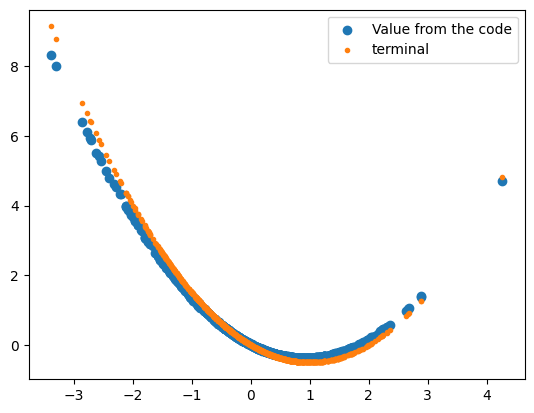

In [129]:
plt.scatter(v.X.detach().numpy(),v.Y.detach().numpy(),label='Value from the code');
# plt.scatter(v.X.detach().numpy(),v(v.X).detach().numpy(),label='control');
# plt.scatter(v.X.detach().numpy(),v.terminal(v.X).detach().numpy(),label='value2');
plt.scatter(v.X.detach().numpy(),g(v.X).detach().numpy(),label='terminal',marker='.');
# plt.scatter(v.X.detach().numpy(),Y1.detach().numpy(),label='Value evaluated manually',marker='.');
# plt.scatter(v.X.detach().numpy(),Y2.detach().numpy(),label='Value2',marker='.',s=0.2, color='k');
# plt.scatter(v.X.detach().numpy(),dY.detach().numpy(),label='DY');
# plt.scatter(v.X.detach().numpy(),dU.detach().numpy(),label='DU',marker='.');
# plt.scatter(v.X.detach().numpy(),torch.mean(v.terminal(update1),axis=1).detach().numpy(),label='U1');
# plt.scatter(v.X.detach().numpy(),torch.mean(v.terminal(update2),axis=1).detach().numpy(),label='U2');
plt.legend();

In [130]:
vval = terminal('')

In [131]:
x = torch.linspace(-1,1,4).unsqueeze(1)
vval(x)

tensor([[ 0.5061],
        [ 0.3512],
        [ 0.1660],
        [-0.0083]], grad_fn=<AddmmBackward0>)

In [132]:
# for p in v.parameters():
#     p.requires_grad = False

In [133]:
loss_epochv = []
num_epochs = 1000
lrv = 1e-2
optimizerv = optim.Adam(vval.parameters(), lrv)
L_ = torch.Tensor([-2.0])
loss = torch.Tensor([2.0])
epoch=0
while (torch.abs(L_-loss)>1e-6) & (epoch <= num_epochs):# epoch in range(num_epochs):
  optimizerv.zero_grad()
  loss= torch.mean(torch.pow(vval(v.X.clone().detach())-v.Y.clone().detach(),2))#
  loss.backward()
  optimizerv.step()
  loss_epochv.append(loss)
  if epoch>0:
    L_ = loss_epochv[epoch-1]
  if (epoch % 10==0):
    print("At epoch {} the mean error is {}.".format(epoch,loss.detach()))
  epoch += 1

At epoch 0 the mean error is 0.9252443313598633.
At epoch 10 the mean error is 0.5160282850265503.
At epoch 20 the mean error is 0.46005192399024963.
At epoch 30 the mean error is 0.3698795735836029.
At epoch 40 the mean error is 0.30051329731941223.
At epoch 50 the mean error is 0.23536895215511322.
At epoch 60 the mean error is 0.17954044044017792.
At epoch 70 the mean error is 0.1378997564315796.
At epoch 80 the mean error is 0.11014258861541748.
At epoch 90 the mean error is 0.09240507334470749.
At epoch 100 the mean error is 0.07991109043359756.
At epoch 110 the mean error is 0.07033183425664902.
At epoch 120 the mean error is 0.0626906156539917.
At epoch 130 the mean error is 0.05640959367156029.
At epoch 140 the mean error is 0.05117195099592209.
At epoch 150 the mean error is 0.04674265906214714.
At epoch 160 the mean error is 0.04293078929185867.
At epoch 170 the mean error is 0.03960350528359413.
At epoch 180 the mean error is 0.03666394576430321.
At epoch 190 the mean error 

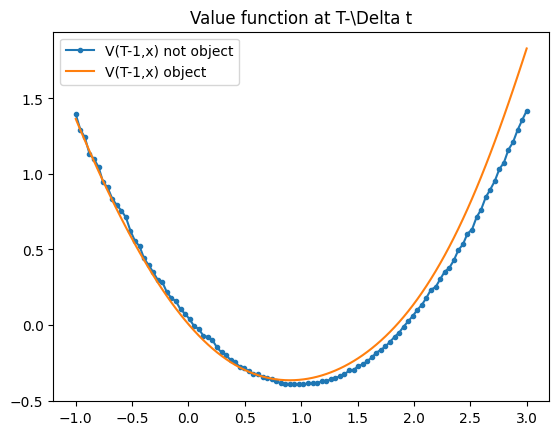

In [134]:
xx = torch.linspace(-1.0,3.0,100).unsqueeze(1)
update = (xx + Dt*(-xx+v.forward(xx))).repeat([1,1000]).unsqueeze(2) + torch.sqrt(Dt)*torch.normal(0., 1., size=[xx.shape[0],v.M,1])
yy = v.cost(xx)*Dt+torch.mean(v.terminal(update),axis=1)
zz = vval(xx)
plt.plot(xx.squeeze(1).detach().numpy(),yy.squeeze(1).detach().numpy(),label='V(T-1,x) not object',marker='.');
plt.plot(xx.squeeze(1).detach().numpy(),zz.squeeze(1).detach().numpy(),label='V(T-1,x) object');
plt.title("Value function at T-\Delta t");
plt.legend();
plt.savefig(path+'test for value'+stamp+'.png');

## Two-step

In [140]:
class two_step(nn.Module):
    def __init__(self,terminal,flag):
        super(two_step, self).__init__()
        self.layer = torch.nn.Sequential()
        self.layer.add_module("L1",torch.nn.Linear(1, 16))
        self.layer.add_module("Tanh", torch.nn.Tanh())
        self.layer.add_module("L2",torch.nn.Linear(16,1))
        self.flag = flag
        self.M = 100
        self.num_steps = 2
        self.N = torch.normal(0., 1., size=[self.M,self.num_steps])
        self.terminal = terminal
        self.X = torch.normal(0., 1., size=(self.M,1))#traning set
        self.Y = None
    def forward(self, x):
        val = self.layer(x)
        return val
    def loss(self):
        #Antithetic variables
        # M = torch.Tensor([0.1])*torch.normal(0., 1., size=[self.M,1]) - torch.Tensor([0.9])*N
        update = self.X
        cost = 0
        for i in range(0,self.num_steps):
            cost +=  self.cost(update)
            # print(update.shape,self.N[:,i].shape)
            update += (-update+self.forward(update))*Dt + torch.sqrt(Dt)*self.N[:,i].unsqueeze(1)
        # print("update shape in loss",update.shape)
        return torch.mean(cost*Dt+self.terminal(update))
    def cost(self,x):#take a [N,1] tensor
        return torch.Tensor([0.5])*torch.pow(x,2) + torch.Tensor([0.5])*torch.pow(self.forward(x),2)
    def value(self):# to evaluate value function through conditional expectation
        update = self.X.repeat([1,self.M]).unsqueeze(2)
        cost = 0
        for i in range(0,self.num_steps):
            cost +=  self.cost(update)
            update += (Dt*(-update+self.forward(update))) + torch.sqrt(Dt)*torch.normal(0., 1., size=[self.X.shape[0],self.M,1])
        # print("update shape in loss",update.shape)
        self.Y = torch.mean(cost*Dt+self.terminal(update),axis=1)

In [141]:
v2 = two_step(g,'')
v2.value()

In [144]:
torch.autograd.set_detect_anomaly(True)

In [143]:
loss_epoch = []
num_epochs = 100
lr = 1e-2
optimizer2 = optim.Adam(v2.parameters(), lr)
L_ = torch.Tensor([-2.0])
loss = torch.Tensor([2.0])
epoch=0
while (torch.abs(L_-loss)>1e-6) & (epoch <= num_epochs):# epoch in range(num_epochs):
  optimizer2.zero_grad()
  loss= v2.loss()#self.cost(self.X,self.modelu(X))+ torch.mean(self.terminal(update(self.X,self.modelu(X))))#
  loss.backward()
  optimizer2.step()
  loss_epoch.append(loss)
  if epoch>0:
    L_ = loss_epoch[epoch-1]
  if (epoch % 10==0):
    print("At epoch {} the mean error is {}.".format(epoch,loss.detach()))
  epoch += 1

RuntimeError: ignored

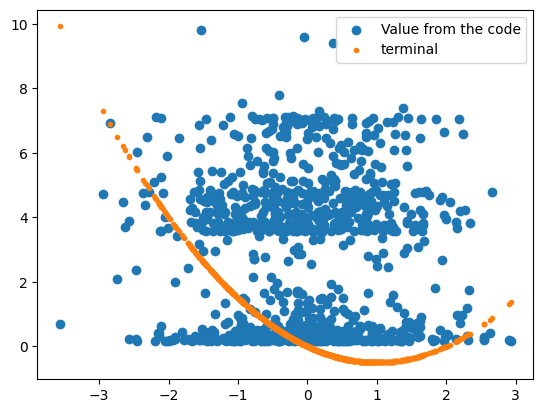

In [97]:
v2.value()
plt.scatter(v.X.detach().numpy(),v2.Y.detach().numpy(),label='Value from the code');
plt.scatter(v.X.detach().numpy(),g(v.X).detach().numpy(),label='terminal',marker='.');
plt.legend();

# Conditional expectation

To evaluate $\mathbb{E}[c(t,x,u)+\phi(x,\xi)]$ in Step 1, we need to create a module that evaluate expected value using a set of samples of $\xi$.
Such module must evaluate the expected value a a function of $x$. To do this, we use the following two wellknown theorems about conditional expectation


  1) If $X$ and $\xi$ are independent, then $\mathbb{E}[\phi(X,\xi)|X]= \Phi(X)$, where $\Phi(x)=\mathbb{E}[\phi(x,\xi)]$.

  2) $\mathbb{E}[Y|X]=f(X)$, where $f(x)$ is the minimizer of $\mathbb{E}[(Y-f(X))^2]$.



## Neural network approximation of conditional expectation

$\inf_{\theta}\mathbb{E}[(Y-\phi(X;\theta))^2]$

and $\phi(x;\theta)$ is a neural network with parameter $\theta$.

## Test examples using neural networks

Let's write a module that takes samples of $(X,Y)$ and returns $\mathbb{E}[Y|X=x]$

Example: $X$ standard normal and $Y=e^{-X}+e^X\xi$ where $\xi$ is standard normal independent of $X$. We know $\mathbb{E}[Y|X]=e^{-X}$.

In [40]:
#hyperparameters for learning
lr = 1e-3
num_epochs = 10000
torch.set_printoptions(precision=10)
loss_epoch = torch.zeros(num_epochs)

In [41]:
def loss_fun(y,x,model):# y :samples for $Y$, x: samples for x, model: nn
  return torch.mean(torch.pow(model(x)-y,2))


In [51]:
'''conditional expectation of X[1,:] given X[0,:] in for of trained model'''
def cond_expect(data, model):
  optimizer = optim.Adam(model.parameters(), lr)
  L_ = torch.Tensor([-2.0])
  loss = torch.Tensor([2.0])
  epoch=0
  while (torch.abs(L_-loss)>1e-6) & (epoch <= num_epochs):# epoch in range(num_epochs):
    optimizer.zero_grad()
    loss=loss_fun(data[:,1].unsqueeze(1),data[:,0].unsqueeze(1),model)# Y=data[:,1], X=data[:,0]
    loss.backward()
    optimizer.step()
    loss_epoch[epoch] = loss
    if epoch>0:
      L_ = loss_epoch[epoch-1]
    if (epoch % 100==0):
      print("At epoch {} the mean error is {}.".format(epoch,loss.detach()))
    epoch += 1


In [43]:
# increase neurons
model3= torch.nn.Sequential(
    torch.nn.Linear(1, 16),
    torch.nn.Tanh(),
    # torch.nn.Sigmoid(),
    # torch.nn.ReLU(),
    torch.nn.Linear(16,1)
)

In [44]:
data = torch.cat((X,Y),dim=1)
cond_expect(data,model3)


At epoch 0 the mean error is 14.38145637512207.
At epoch 100 the mean error is 13.252371788024902.
At epoch 200 the mean error is 13.09913158416748.
At epoch 300 the mean error is 13.083439826965332.


In [45]:
Z = torch.normal(0., 1., size=(M,1))
W = torch.exp(-Z)+torch.exp(Z)*torch.normal(0., 1., size=(M,1))
torch.set_printoptions(precision=10)
print("Test on new data: MSE = {}".format(loss_fun(W,Z,model3)))

Test on new data: MSE = 12.280806541442871


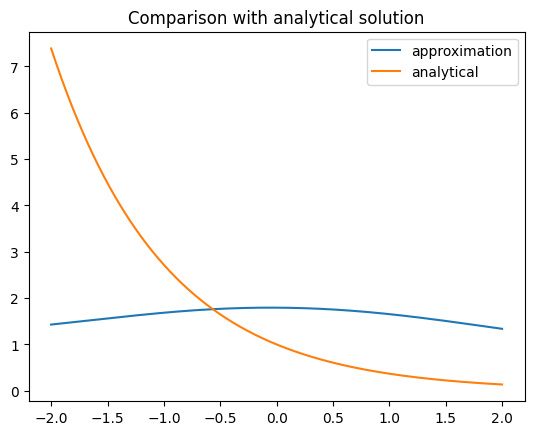

In [46]:
xx = torch.linspace(-2,2,600)
yy = model3(xx.unsqueeze(1))
plt.plot(xx.detach().numpy(),yy.detach().numpy(), label='approximation');
plt.plot(xx.detach().numpy(),np.exp(-xx.detach().numpy()), label='analytical');
plt.title("Comparison with analytical solution");
plt.legend();
plt.savefig(path+'test for model3'+stamp+'.png');

### **Evaluation of conditional expectation using deep learning is cool and all, but it is slow and causes some issue while training the neural net for the control. Therefore, we have to change our approach.**

# Scratch coding

##########################################

In [47]:
#hyperparameters for learning
lr = 1e-3
num_epochs = 1000
torch.set_printoptions(precision=10)
loss_epoch = torch.zeros(num_epochs)
optimizer = optim.Adam(modelu.parameters(), lr)
# scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1e-1, end_factor=1e-5, total_iters=100)

In [48]:
'''conditional expectation of X[1,:] given X[0,:] in for of trained model'''
def oneStep(data, model):
  optimizer = optim.Adam(model.parameters(), lr)
  L_ = torch.Tensor([-2.0])
  loss = torch.Tensor([2.0])
  epoch=0
  while (torch.abs(L_-loss)>1e-4) & (epoch <= num_epochs):# epoch in range(num_epochs):
    optimizer.zero_grad()
    loss=loss_fun(data[:,1].unsqueeze(1),data[:,0].unsqueeze(1),model)# Y=data[:,1], X=data[:,0]
    loss.backward()
    optimizer.step()
    loss_epoch[epoch] = loss
    if epoch>0:
      L_ = loss_epoch[epoch-1]
    if (epoch % 100==0):
      print("At epoch {} the mean error is {}.".format(epoch,loss.detach()))
    epoch += 1


In [49]:
#saving the model
torch.save(model1, path+"model1_"+str(stamp)+".pt")

NameError: ignored

In [ ]:
# write loss into a daraframe
df_loss = pd.DataFrame([range(num_epochs), loss_epoch.detach().numpy()]).T
df_loss.columns = ['Epoch','Loss']
df_loss['Epoch'] = df_loss['Epoch'].astype('int64')
df_loss.to_csv(path+"run_model1_"+str(stamp)+".csv",sep=",")

In [ ]:
# testing
Z = torch.normal(0., 1., size=(M,1))
W = torch.exp(-Z)+torch.exp(Z)*torch.normal(0., 1., size=(M,1))
torch.set_printoptions(precision=10)
print("Test on new data: MSE = {}".format(loss_fun(W,Z,model1)))

In [ ]:
n = np.linspace(0,num_epochs,num_epochs)
m = loss_epoch.detach().numpy()
plt.plot(n,m);
plt.title("Loss vs number of pochs in model1");
plt.savefig(path+'loss_vs_epoch_model1'+stamp+'.png');

In [ ]:
xx = torch.linspace(-3,3,600)
yy = model1(xx.unsqueeze(1))
plt.plot(xx.detach().numpy(),yy.detach().numpy(), label='approximation');
plt.plot(xx.detach().numpy(),np.exp(-xx.detach().numpy()), label='analytical');
plt.title("Comparison with analytical solution");
plt.legend();
plt.savefig(path+'test for model1'+stamp+'.png');

In [ ]:
def deriv(model,x):
  x_ = x.clone().detach()
  x_.requires_grad_(True)
  u=model(x_)
  return torch.autograd.grad(outputs=u, inputs=x_,grad_outputs=torch.ones_like(u),
                           allow_unused=True,retain_graph=True,create_graph=True)[0]

In [ ]:
xx = torch.linspace(-3,3,600)
yy = deriv(model1,xx.unsqueeze(1))
plt.plot(xx.detach().numpy(),yy.detach().numpy(), label='approximation');
plt.plot(xx.detach().numpy(),-np.exp(-xx.detach().numpy()), label='analytical');
plt.title("Comparison with analytical solution");
plt.legend();
plt.savefig(path+'test for derivative  of model1'+stamp+'.png');

In [ ]:
# increase neurons
model2= torch.nn.Sequential(
    torch.nn.Linear(1, 16),
    torch.nn.ReLU(),
    # torch.nn.Linear(8, 8),
    # torch.nn.ReLU(),
    torch.nn.Linear(16,1)
)

In [ ]:
# create time stamp to save the result
stamp = strftime('%Y-%m-%d %H:%M:%S', localtime())
print(str(stamp))

In [ ]:
#hyperparameters for learning
optimizer = optim.Adam(model2.parameters(), lr)
# scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1e-1, end_factor=1e-5, total_iters=100)

In [ ]:
for epoch in range(num_epochs):
  optimizer.zero_grad()
  loss=loss_fun(Y,X,model2)
  loss.backward()
  optimizer.step()
  loss_epoch[epoch] = loss
  # scheduler.step()
  if (epoch % 1000==-1):
    print("At epoch {} the mean error is {}.".format(epoch,loss.detach()))


In [ ]:
#saving the model
torch.save(model2, path+"model2_"+str(stamp)+".pt")

In [ ]:
# write loss into a daraframe
df_loss = pd.DataFrame([range(num_epochs), loss_epoch.detach().numpy()]).T
df_loss.columns = ['Epoch','Loss']
df_loss['Epoch'] = df_loss['Epoch'].astype('int64')
df_loss.to_csv(path+"run_model2_"+str(stamp)+".csv",sep=",")

In [ ]:
Z = torch.normal(0., 1., size=(M,1))
W = torch.exp(-Z)+torch.exp(Z)*torch.normal(0., 1., size=(M,1))
torch.set_printoptions(precision=10)
print("Test on new data: MSE = {}".format(loss_fun(W,Z,model1)))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
n = np.linspace(0,num_epochs,num_epochs)
m = loss_epoch.detach().numpy()
plt.plot(n,m);
plt.title("Loss vs number of epochs in model2");
plt.savefig(path+'loss_vs_epoch_model2'+stamp+'.png');

In [ ]:
xx = torch.linspace(-2,2,600)
yy = model2(xx.unsqueeze(1))
plt.plot(xx.detach().numpy(),yy.detach().numpy(), label='approximation');
plt.plot(xx.detach().numpy(),np.exp(-xx.detach().numpy()), label='analytical');
plt.title("Comparison with analytical solution");
plt.legend();
plt.savefig(path+'test for model2'+stamp+'.png');

In [ ]:
xx = torch.linspace(-3,3,600)
yy = deriv(model2,xx.unsqueeze(1))
plt.plot(xx.detach().numpy(),yy.detach().numpy(), label='approximation');
plt.plot(xx.detach().numpy(),-np.exp(-xx.detach().numpy()), label='analytical');
plt.title("Comparison with analytical solution");
plt.legend();
plt.savefig(path+'test for derivative  of model2'+stamp+'.png');

## 1.2 Projectin method


One trick to approximate $\mathbb{E}[Y|X]=f(X)$ is to take the minimum over a smaller class of fuctions, e.g., $f(x)=\sum_{k=1}^Ka_k\phi_k(x)$, for a suitable set of functions $\phi_k$. To evluate approximate $f$, we use a joint (unconditional) sample of $(X,Y)$, $\{(x_j,y_j):j=i,...,J\}$ to write

$\inf_{a_1,...,a_K}\sum_{j=1}^J \big(y_j-\sum_{k=1}^Ka_k\phi_k(x_j)\big)^2$

This is a quadratic minimization problem which has a unique solution. To find the minimizer, we take take derivative wrt $a_{k'}$ and set it to zero to obtain a linear system.

$\sum_{j=1}^J \phi_{k'}(x_j)\big(y_j-\sum_{k=1}^Ka_k\phi_k(x_j)\big)=0$

$\sum_{k=1}^Ka_k\sum_{j=1}^J\phi_k(x_j)\phi_{k'}(x_j) = \sum_{j=1}^J \phi_{k'}(x_j)y_j$

or $Ma=b$ with

$a=(a_1,...,a_K)^\top$, $M=[m_{k'k}]$ with $m_{k'k}=\sum_{j=1}^J\phi_{k'}(x_j)\phi_{k}(x_j)$, and $b=(b_1,...,b_K)^\top$ with $b_k=\sum_{j=1}^J\phi_k(x_j)y_j$.

## 1.3. Choosing basis $\phi_k$

It is useful to choose the basis $\phi_k$ such that $m_{k'k}=0$ when $k'\neq k$. Then, the linear system above takes no time to solve: $a_k=b_k/m_{kk}$. Sometimes this is done by using orthogonal polynomials. However, we propose a simpler solution: choose the basis such that $\phi_k(x)$ and $\phi_{k'}(x)$ have disjoint support. For instance, they are indicator functions of hypercubes.
 More detains of this method can be found in the paper [Monte-Carlo valuation of American options: facts and new algorithms to improve existing methods](https://www.ceremade.dauphine.fr/~bouchard/pdf/BW10.pdf).

## 1.3. Simulationg samples of $(X_t,\xi)$
Let $\xi$ be Gaussian, e.g., increment of Brownian motion, we can choose any distribution for $X_t$ independent of $\xi$.

# Step 2 DPP
Start the backward scheme by feeding $C(t,x,u)$ and $g(x)$ into the optimization module and obtain $V(T-1,x)$ over the range of simulated values for $X_{T-1}$.

Repeat the process by feeding $C(t,x,u)$ and $V(t+1,x)$ into the optimization module to obtain $V(t,x)$.

It is important to make sure the simulated samples of $X^u_{t+1}$ are well inside the range in which estimation of $V(t+1,x)$ is rather accurate/